In [101]:
import numpy as np
import pandas as pd
import tensorflow as tf

from mrtoct import data

from matplotlib import pyplot as plt

transform = data.transform.DecodeExample()

def read_volume(path):
    return (tf.data.TFRecordDataset(path, 'GZIP')
            .map(transform)
            .make_one_shot_iterator()
            .get_next())

def mae(x, y):
    return np.abs(x - y).mean()

def psnr(x, y):
    max = np.iinfo(np.uint16).max
    mse = np.square(x - y).mean()
    
    return 20 * np.log10(max / np.sqrt(mse))

def unpad(x, shape):
    height = np.abs(shape[1] - x.shape[1]) / 2
    width = np.abs(shape[2] - x.shape[2]) / 2
    
    start_h = int(np.floor(height))
    start_w = int(np.floor(width))

    end_h = - int(np.ceil(height))
    end_w = - int(np.ceil(width))
    
    return x[:, start_h:end_h, start_w:end_w]

In [110]:
training = {
    'inputs': read_volume('../data/tfrecord/cleaned/mr.tfrecord'),
    'targets': read_volume('../data/tfrecord/cleaned/ct.tfrecord'),
    'unet': read_volume('results/unet/mae2/training.tfrecord'),
    'pixtopix': read_volume('results/pixtopix/lsquare-clean/training.tfrecord'),
    'pixtopix-masking': read_volume('results/pixtopix/lsquare-clean/training2.tfrecord'),
}

validation = {
    'inputs': read_volume('../data/tfrecord/cleaned/validation-mr.tfrecord'),
    'targets': read_volume('../data/tfrecord/cleaned/validation-ct.tfrecord'),
    'unet': read_volume('results/unet/mae2/validation.tfrecord'),
    'pixtopix': read_volume('results/pixtopix/lsquare-clean/validation.tfrecord'),
    'pixtopix-masking': read_volume('results/pixtopix/lsquare-clean/validation2.tfrecord'),
}

session = tf.Session()

In [89]:
mr_t, ct_t, unet_t, pixtopix_t, pixtopix_mask_t = session.run(list(training.values()))
mr_v, ct_v, unet_v, pixtopix_v, pixtopix_mask_v = session.run(list(validation.values()))

unet_t = unpad(unet_t, ct_t.shape)
pixtopix_t = unpad(pixtopix_t, ct_t.shape)
pixtopix_mask_t = unpad(pixtopix_mask_t, ct_t.shape)

unet_v = unpad(unet_v, ct_v.shape)
pixtopix_v = unpad(pixtopix_v, ct_v.shape)
pixtopix_mask_v = unpad(pixtopix_mask_v, ct_v.shape)

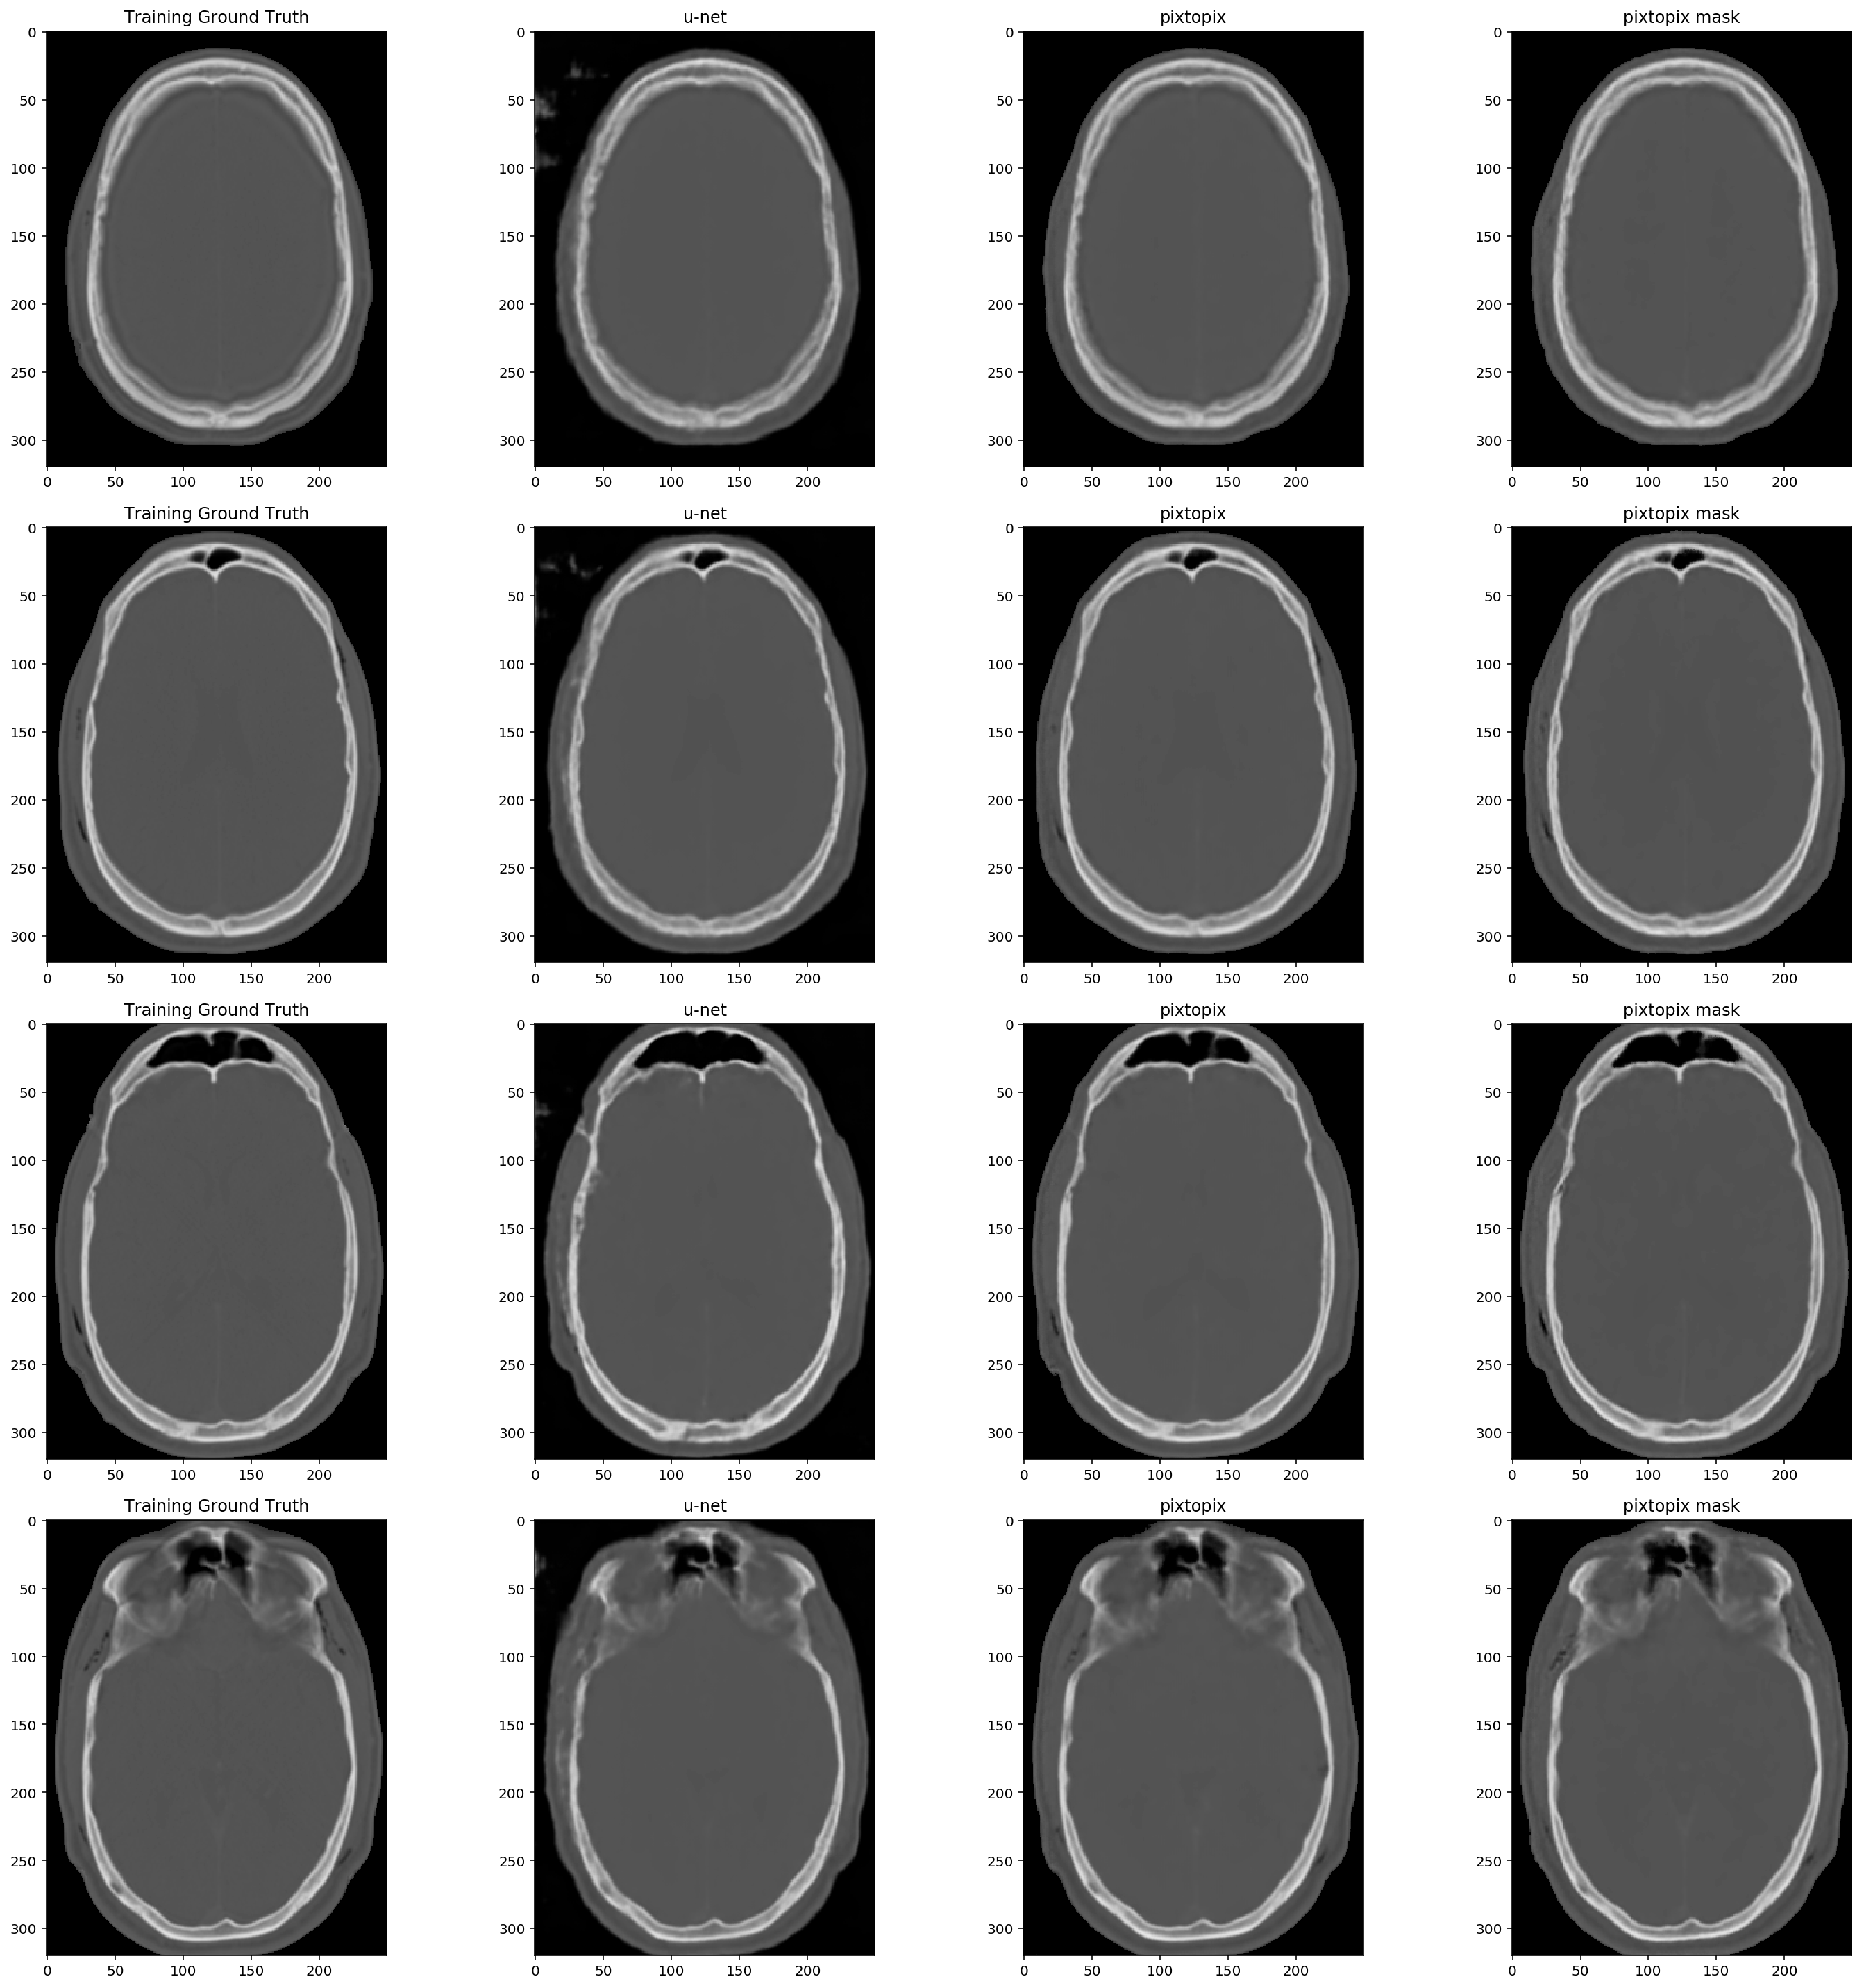

In [94]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

vmin = ct_t.min()
vmax = ct_t.max()

for i, n in enumerate([30, 50, 70, 90]):
    axes[i][0].set_title('Training Ground Truth')
    axes[i][0].imshow(ct_t[n, :, :, 0], cmap='gray', vmin=vmin, vmax=vmax)

    axes[i][1].set_title('u-net')
    axes[i][1].imshow(unet_t[n, :, :,0], cmap='gray', vmin=vmin, vmax=vmax)

    axes[i][2].set_title('pixtopix')
    axes[i][2].imshow(pixtopix_t[n, :, :,0], cmap='gray', vmin=vmin, vmax=vmax)

    axes[i][3].set_title('pixtopix mask')
    axes[i][3].imshow(pixtopix_mask_t[n, :, :,0], cmap='gray', vmin=vmin, vmax=vmax)

fig.tight_layout()
plt.show()

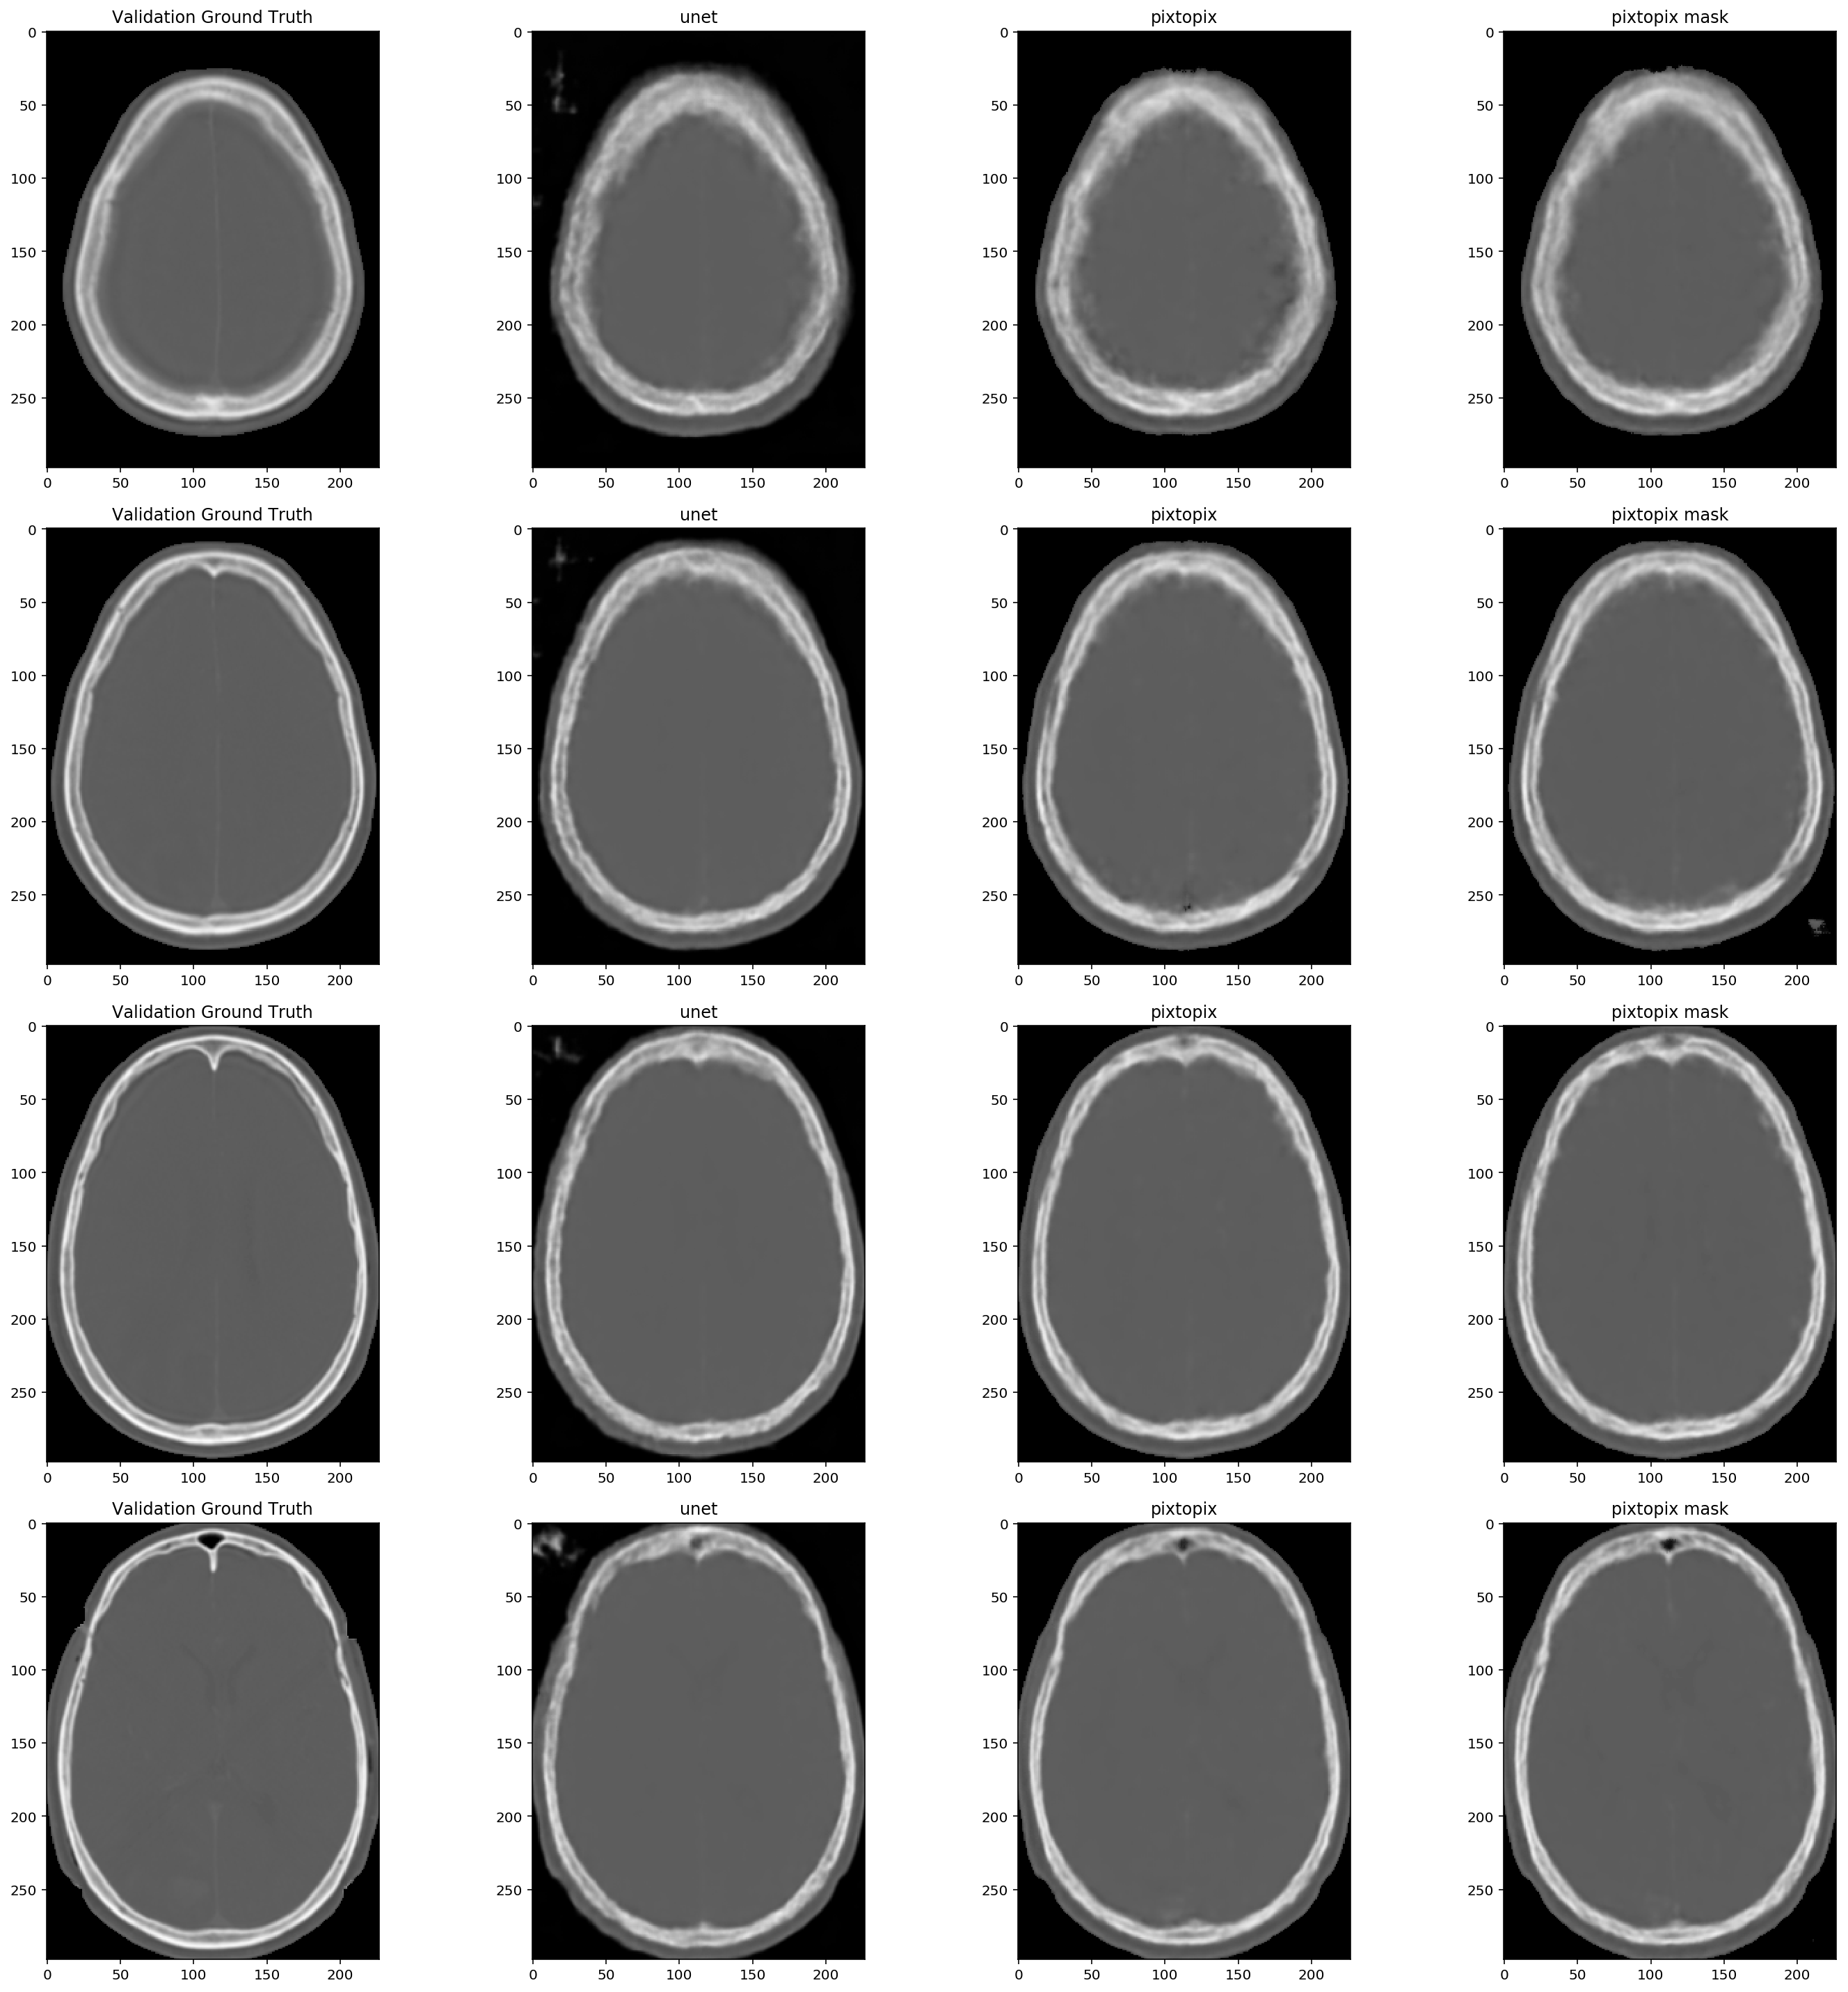

In [95]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

vmin = ct_v.min()
vmax = ct_v.max()

for i, n in enumerate([30, 50, 70, 90]):
    axes[i][0].set_title('Validation Ground Truth')
    axes[i][0].imshow(ct_v[n, :, :, 0], cmap='gray', vmin=vmin, vmax=vmax)

    axes[i][1].set_title('unet')
    axes[i][1].imshow(unet_v[n, :, :,0], cmap='gray', vmin=vmin, vmax=vmax)

    axes[i][2].set_title('pixtopix')
    axes[i][2].imshow(pixtopix_v[n, :, :,0], cmap='gray', vmin=vmin, vmax=vmax)

    axes[i][3].set_title('pixtopix mask')
    axes[i][3].imshow(pixtopix_mask_v[n, :, :,0], cmap='gray', vmin=vmin, vmax=vmax)

fig.tight_layout()
plt.show()

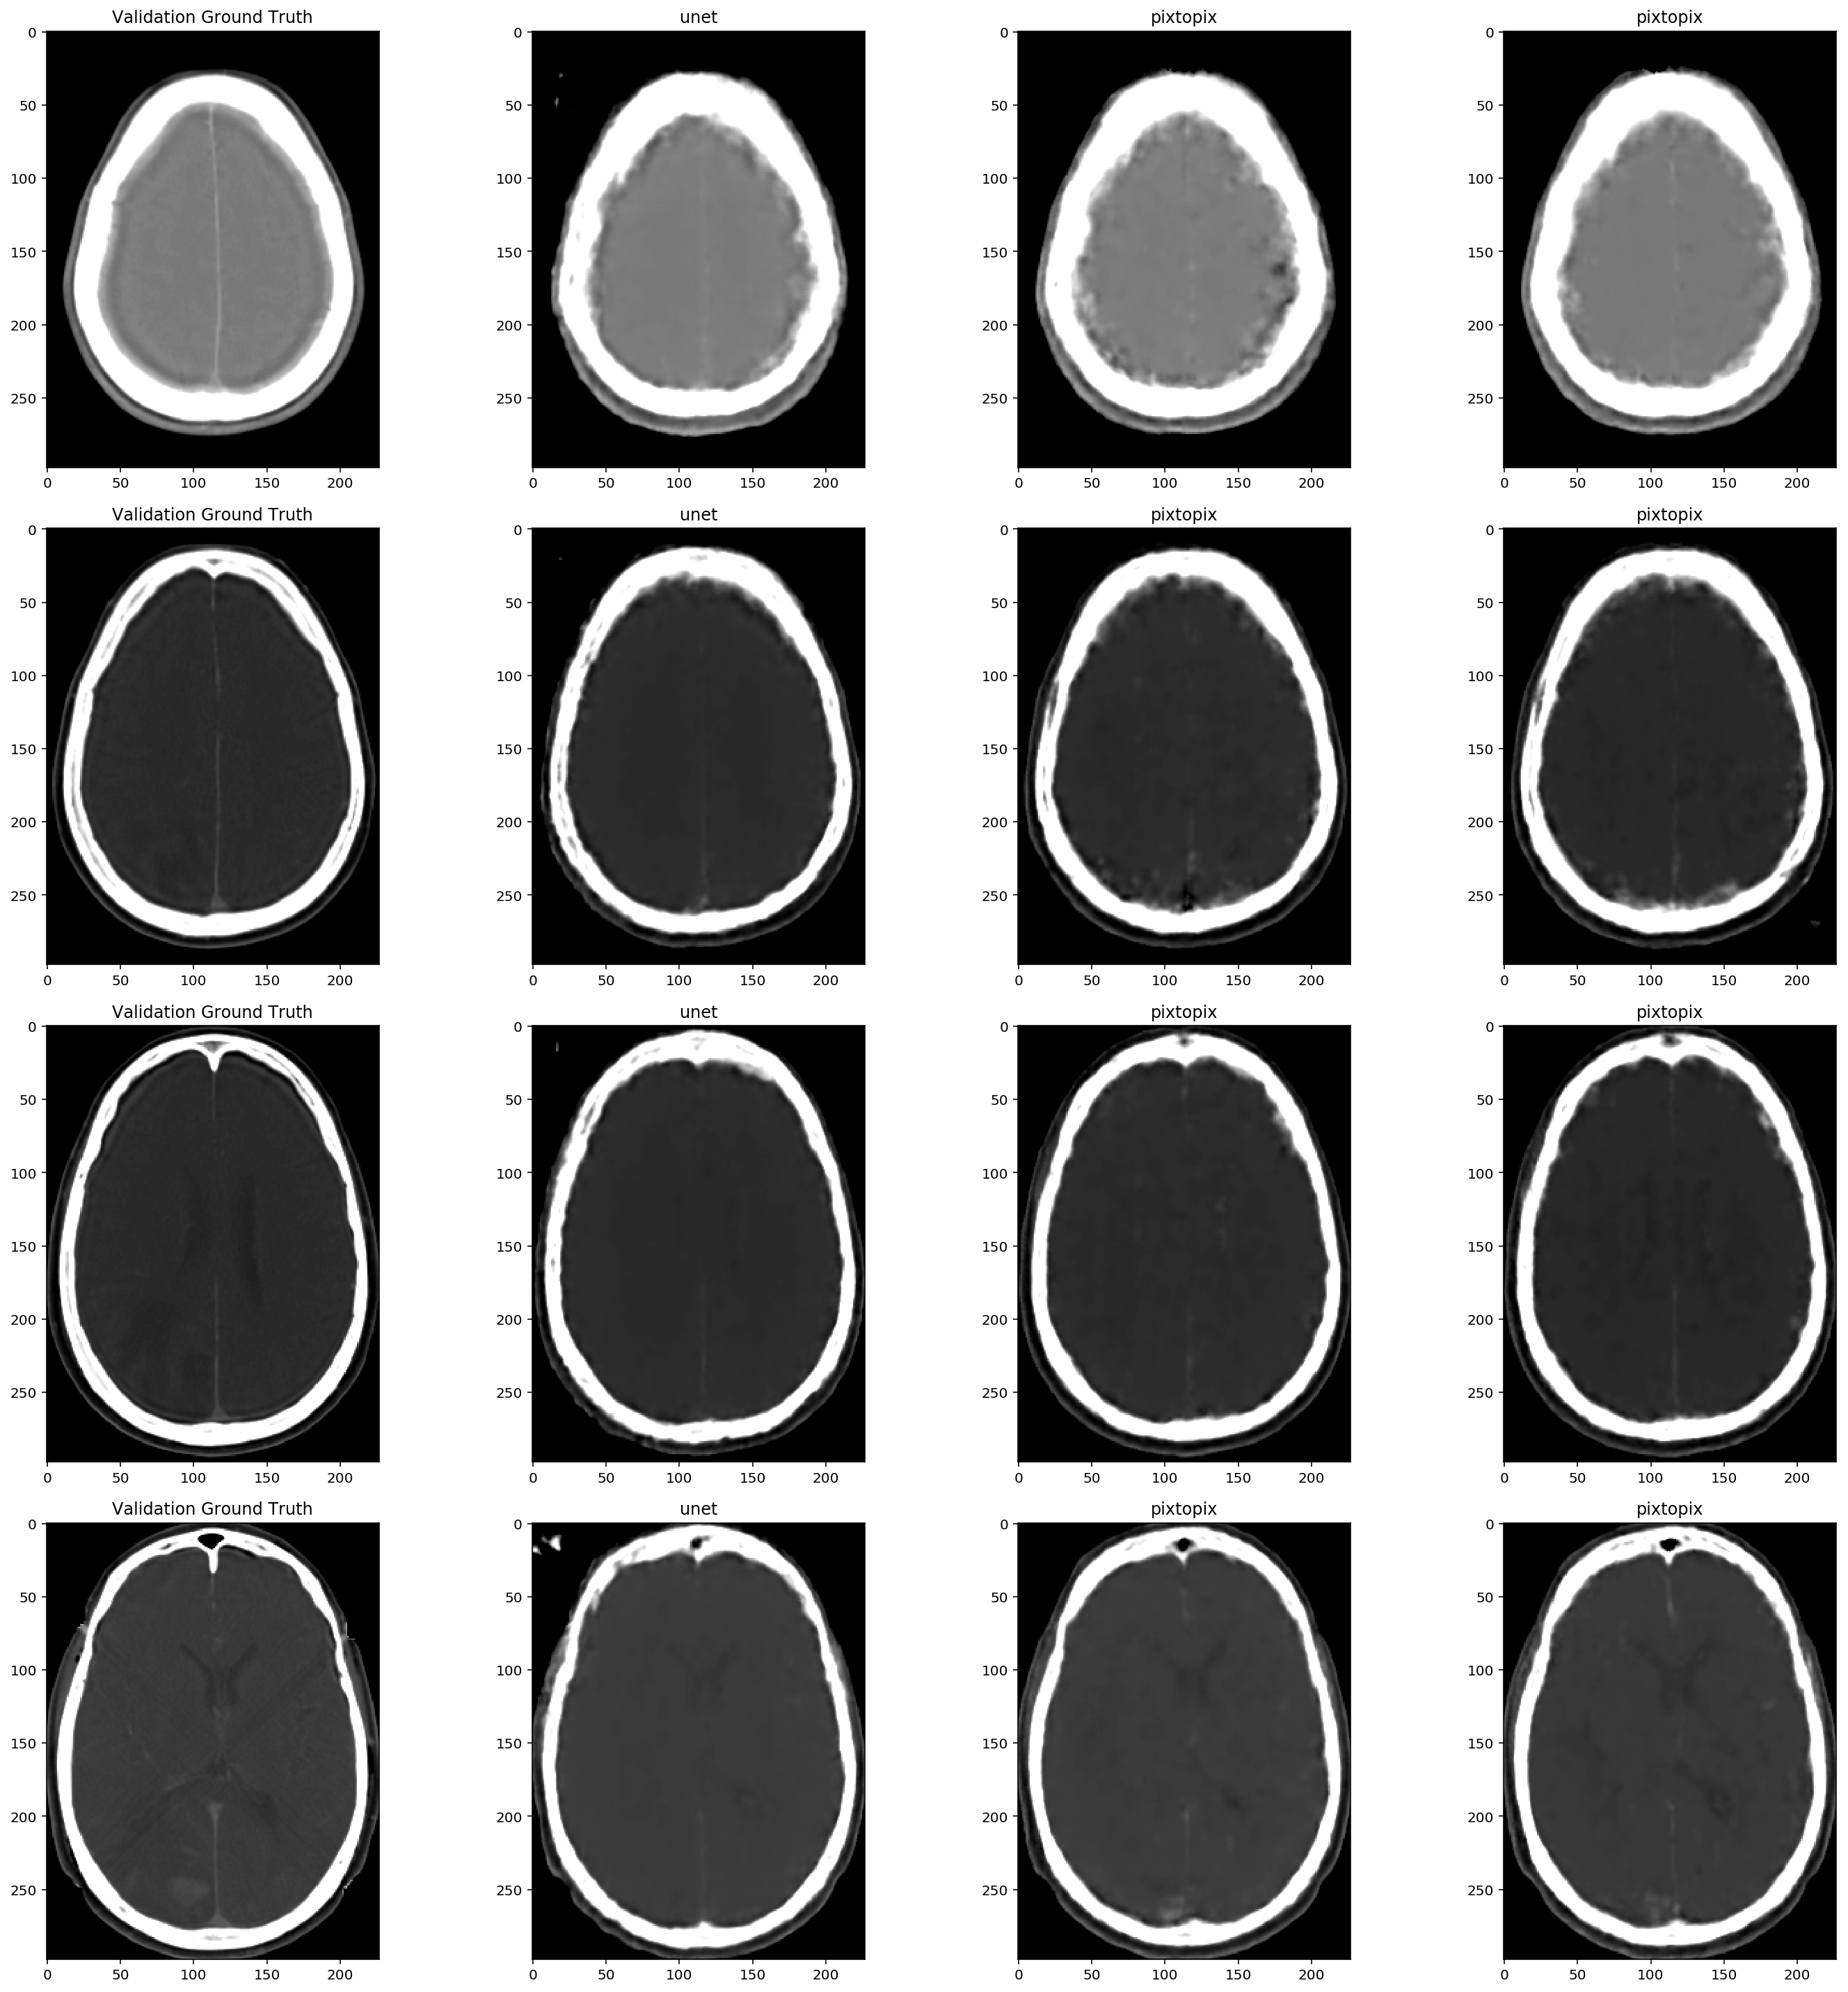

In [100]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))


for i, n in enumerate([30, 50, 70, 90]):
    vmin = ct_v[n, 100:120, 100:200,0].min() - 100
    vmax = ct_v[n, 100:120, 100:200,0].min() + 700
    
    axes[i][0].set_title('Validation Ground Truth')
    axes[i][0].imshow(ct_v[n, :, :, 0], cmap='gray', vmin=vmin, vmax=vmax)

    axes[i][1].set_title('unet')
    axes[i][1].imshow(unet_v[n, :, :, 0], cmap='gray', vmin=vmin, vmax=vmax)

    axes[i][2].set_title('pixtopix')
    axes[i][2].imshow(pixtopix_v[n, :, :, 0], cmap='gray', vmin=vmin, vmax=vmax)

    axes[i][3].set_title('pixtopix')
    axes[i][3].imshow(pixtopix_mask_v[n, :, :, 0], cmap='gray', vmin=vmin, vmax=vmax)

fig.tight_layout()
plt.show()

In [104]:
unet_t_mae = []
unet_t_psnr = []

pixtopix_t_mae= []
pixtopix_t_psnr = []

pixtopix_mask_t_mae= []
pixtopix_mask_t_psnr = []

try:
    while True:
        mr_t, ct_t, unet_t, pixtopix_t, pixtopix_mask_t = session.run(list(training.values()))
    
        unet_t = unpad(unet_t, ct_t.shape)
        pixtopix_t = unpad(pixtopix_t, ct_t.shape)
        pixtopix_mask_t = unpad(pixtopix_mask_t, ct_t.shape)
    
        unet_t_mae.append(mae(unet_t, ct_t))
        unet_t_psnr.append(psnr(unet_t, ct_t))
        
        pixtopix_t_mae.append(mae(pixtopix_t, ct_t))
        pixtopix_t_psnr.append(psnr(pixtopix_t, ct_t))
        
        pixtopix_mask_t_mae.append(mae(pixtopix_mask_t, ct_t))
        pixtopix_mask_t_psnr.append(psnr(pixtopix_mask_t, ct_t))
except:
    pass

df_t = pd.DataFrame({
    'unet (mae)': unet_t_mae,
    'unet (psnr)': unet_t_psnr,
    'pixtopix (mae)': pixtopix_t_mae,
    'pixtopix (psnr)': pixtopix_t_psnr,
    'pixtopix mask (mae)': pixtopix_mask_t_mae,
    'pixtopix mask (psnr)': pixtopix_mask_t_psnr,
})

In [105]:
df_t

,pixtopix (mae),pixtopix (psnr),pixtopix mask (mae),pixtopix mask (psnr),unet (mae),unet (psnr)
0,23.649215,59.954497,25.139089,60.327166,94.344204,48.107980
1,23.318634,60.031245,23.170126,60.946900,60.673745,52.191833
2,20.699522,60.743885,20.055294,61.260496,137.355590,45.640342
3,18.456842,61.687135,21.715897,61.103453,129.287527,45.864292
4,14.812878,63.039850,20.257198,61.273809,45.805909,54.574891
5,16.020560,62.523095,20.599917,61.236814,64.035446,52.161836
6,16.481202,59.771326,20.303158,59.079878,57.564510,51.464543
7,21.008888,60.172309,18.911524,61.414116,151.252333,45.285674
8,32.338338,56.864679,30.093542,57.947046,74.017665,50.512957
9,23.992954,59.731339,28.049235,59.181663,62.377832,51.472684


In [106]:
df_t.mean()

pixtopix (mae)          21.559681
pixtopix (psnr)         60.379152
pixtopix mask (mae)     23.372004
pixtopix mask (psnr)    60.303171
unet (mae)              90.463114
unet (psnr)             49.367599
dtype: float64

In [111]:
unet_v_mae= []
unet_v_psnr = []

pixtopix_v_mae= []
pixtopix_v_psnr = []

pixtopix_mask_v_mae= []
pixtopix_mask_v_psnr = []

try:
    while True:
        mr_v, ct_v, unet_v, pixtopix_v, pixtopix_mask_v = session.run(list(validation.values()))
    
        unet_v = unpad(unet_v, ct_v.shape)
        pixtopix_v = unpad(pixtopix_v, ct_v.shape)
        pixtopix_mask_v = unpad(pixtopix_mask_v, ct_v.shape)
    
        unet_v_mae.append(mae(unet_v, ct_v))
        unet_v_psnr.append(psnr(unet_v, ct_v))
    
        pixtopix_v_mae.append(mae(pixtopix_v, ct_v))
        pixtopix_v_psnr.append(psnr(pixtopix_v, ct_v))
    
        pixtopix_mask_v_mae.append(mae(pixtopix_mask_v, ct_v))
        pixtopix_mask_v_psnr.append(psnr(pixtopix_mask_v, ct_v))
except:
    pass

df_v = pd.DataFrame({
    'unet (mae)': unet_v_mae,
    'unet (psnr)': unet_v_psnr,
    'pixtopix (mae)': pixtopix_v_mae,
    'pixtopix (psnr)': pixtopix_v_psnr,
    'pixtopix mask (mae)': pixtopix_mask_v_mae,
    'pixtopix mask (psnr)': pixtopix_mask_v_psnr,
})

In [112]:
df_v

,pixtopix (mae),pixtopix (psnr),pixtopix mask (mae),pixtopix mask (psnr),unet (mae),unet (psnr)
0,77.430012,50.460531,77.258002,50.550289,88.392491,50.136599
1,105.078784,47.506501,105.985223,47.654811,130.798395,46.421931
2,144.761320,45.314445,140.968711,45.585354,190.615336,43.930198
3,123.637395,46.910566,124.725972,46.936279,137.905454,46.574705


In [114]:
df_v.mean()

pixtopix (mae)          112.726878
pixtopix (psnr)          47.548011
pixtopix mask (mae)     112.234477
pixtopix mask (psnr)     47.681683
unet (mae)              136.927919
unet (psnr)              46.765858
dtype: float64